# Conditional Flow Matching (CFM)

A simple tutorial of Conditional Flow Matching (CFM) [Lipman22] using MNIST dataset.

Author: Minsu Kang

Email: mskang1478@gmail.com

In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

from tqdm import tqdm
from torch.optim import Adam

In [2]:
dataset_path = '~/datasets'

dataset = "MNIST"
gpu_id = 0
cuda = True

hidden_dim = 256
n_layers = 8

lr = 5e-5
sigma_min = 0

n_epochs = 200
train_batch_size = 128

inference_batch_size = 64

seed = 1234


DEVICE = torch.device("cuda:{}".format(gpu_id) if cuda else "cpu")
img_size = (32, 32, 3)   if dataset == "CIFAR10" else (28, 28, 1) # (width, height, channels)
hidden_dims = [hidden_dim for _ in range(n_layers)]

torch.manual_seed(seed)
np.random.seed(seed)

## Step 1. Load (or download) Dataset

In [3]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

if dataset == 'CIFAR10':
    train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = CIFAR10(dataset_path, transform=transform, train=False, download=True)
else:
    train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False,  **kwargs)

## Step 2. Define our model: Conditional Flow Matching (CFM)

In this tutorial, we use **Example-2: Optimal Transport conditional Vector Fields** which is proposed in the paper.

For comparison, we use a simple stacked-convolution model with various dilations as like [Denoising Diffusion Probabilistic Model(DDPM) tutorial](https://github.com/Jackson-Kang/Pytorch-Diffusion-Model-Tutorial). The number of trainable parameters and other details are almost same.

In [4]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
        
    def forward(self, x, time_embedding=None, residual=False):
        
        if residual:
            # timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y
        
        return y

In [5]:
class Model(nn.Module):
    
    def __init__(self, image_resolution, hidden_dims=[256, 256], sigma_min=0.):
        super(Model, self).__init__()
        
        _, _, img_C = image_resolution
        
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)
        
        self.time_project = nn.Sequential(
                                 ConvBlock(1, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[1], kernel_size=1))
        
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])
        
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))                                
                               
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)
        self.sigma_min = sigma_min

    def get_velocity(self, x_0, x_1):        
        """
            Target velocity (or vector field). 
                This vector field generates conditional probabilistic path 
                    that maps a sampled noise from Gaussian normal to target data distribution
        """
        return (x_1 - (1-self.sigma_min) * x_0)
    
    def interpolate(self, x_0, x_1, t):
        """
            Conditional flow, psai_t(x_0) that corresponds to u_t(x | x_1).
                Since we use Optimal Transport conditional VFs, 
                    we simply use linear interpolation between noise(x_0) and target sample(x_1).
        """
        return (1 - (1-self.sigma_min) * t) *  x_0 + t * x_1
    
    
    def forward(self, x, t):
        """
            Estimate vector field given x_t and time embedding.
        """
        
        time_embedding = self.time_project(t)
        y = self.in_project(x)
        
        for i in range(len(self.convs)):
            y = self.convs[i](y, time_embedding, residual=True)
            
        v_t = self.out_project(y)
        return v_t

    @torch.no_grad()
    def sample(self, t_steps, shape, DEVICE):

        """
            move x_0 (located in noise distribution) to x_1 (located in target data distribution)
        """

        B, C, W, H = shape
        
        x_0 = torch.randn(size=shape, device=DEVICE)
        t_vals = torch.linspace(0, 1, t_steps, device=DEVICE)
        delta = 1.0 / (t_steps - 1)

        x_1_hat = x_0
        for i in range(t_steps - 1):
            t_cur = t_vals[i].view(-1, 1, 1, 1)
            velocity_pred = self(x_1_hat, t_cur)
            x_1_hat = x_1_hat + velocity_pred * delta
            
        return x_1_hat

    
model = Model(image_resolution=img_size,
                 hidden_dims=hidden_dims, sigma_min=sigma_min).to(DEVICE)

In [6]:
optimizer = Adam(model.parameters(), lr=lr)

## Step 3. Train Conditional Flow Matching(CFM).

In [7]:
print("Start training CFM...")
model.train()

for epoch in range(n_epochs):
    total_loss = 0
    for batch_idx, (x_1, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        # sample Gaussian normal and target data
        x_1 = x_1.to(DEVICE)
        x_0 = torch.randn_like(x_1)
        t = torch.rand(x_1.shape[0], 1, 1, 1, device=DEVICE)

        # get noise-interpolated data
        x_t = model.interpolate(x_0, x_1, t)

        # target velocity
        velocity_target = model.get_velocity(x_0, x_1)
        # estimate velocity
        velocity_pred = model(x_t, t)

        # conditional flow matching loss. model learns 
        loss = ((velocity_pred - velocity_target) ** 2).mean()
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tCFM Loss: ", total_loss / len(train_loader))
    
print("Finish!!")

Start training CFM...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:01<00:00,  7.57it/s]

	Epoch 1 complete! 	CFM Loss:  0.20312397353557635



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:02<00:00,  7.46it/s]

	Epoch 2 complete! 	CFM Loss:  0.12561466405068888



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:03<00:00,  7.41it/s]

	Epoch 3 complete! 	CFM Loss:  0.11616405776378189



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:03<00:00,  7.37it/s]

	Epoch 4 complete! 	CFM Loss:  0.11216884517847601



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:03<00:00,  7.35it/s]

	Epoch 5 complete! 	CFM Loss:  0.10918240268220271



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:03<00:00,  7.35it/s]

	Epoch 6 complete! 	CFM Loss:  0.10706872377060116



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:03<00:00,  7.35it/s]

	Epoch 7 complete! 	CFM Loss:  0.10520196782309872



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:03<00:00,  7.35it/s]

	Epoch 8 complete! 	CFM Loss:  0.104438839420708



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:03<00:00,  7.33it/s]

	Epoch 9 complete! 	CFM Loss:  0.10243158376038965



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:03<00:00,  7.33it/s]

	Epoch 10 complete! 	CFM Loss:  0.10156209024983937



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:03<00:00,  7.33it/s]

	Epoch 11 complete! 	CFM Loss:  0.10057831722408977



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.32it/s]

	Epoch 12 complete! 	CFM Loss:  0.09970690066944053



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.32it/s]

	Epoch 13 complete! 	CFM Loss:  0.09906357574437473



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.33it/s]

	Epoch 14 complete! 	CFM Loss:  0.0985462573895068



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.30it/s]

	Epoch 15 complete! 	CFM Loss:  0.09799034992006542



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.31it/s]

	Epoch 16 complete! 	CFM Loss:  0.09732733508035826



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.32it/s]

	Epoch 17 complete! 	CFM Loss:  0.09684802687117286



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.32it/s]

	Epoch 18 complete! 	CFM Loss:  0.09656695985018826



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.30it/s]

	Epoch 19 complete! 	CFM Loss:  0.09641362534466583



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 20 complete! 	CFM Loss:  0.09547009425503868



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.30it/s]

	Epoch 21 complete! 	CFM Loss:  0.09563099599278557



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.28it/s]

	Epoch 22 complete! 	CFM Loss:  0.09516578642671296



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.30it/s]

	Epoch 23 complete! 	CFM Loss:  0.09481104115433277



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 24 complete! 	CFM Loss:  0.09478738297150334



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 25 complete! 	CFM Loss:  0.09399390419218331



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 26 complete! 	CFM Loss:  0.09384024778662968



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 27 complete! 	CFM Loss:  0.09387936039583515



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 28 complete! 	CFM Loss:  0.09375417141962661



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 29 complete! 	CFM Loss:  0.0930279177198532



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 30 complete! 	CFM Loss:  0.09305320514926016



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 31 complete! 	CFM Loss:  0.09249864758522526



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 32 complete! 	CFM Loss:  0.09268327473577406



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 33 complete! 	CFM Loss:  0.09241700467905764



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 34 complete! 	CFM Loss:  0.0924446176427768



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.29it/s]

	Epoch 35 complete! 	CFM Loss:  0.09227661024342214



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.30it/s]

	Epoch 36 complete! 	CFM Loss:  0.09231844588891784



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.30it/s]

	Epoch 37 complete! 	CFM Loss:  0.09201016663107028



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.27it/s]

	Epoch 38 complete! 	CFM Loss:  0.09163098283477429



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.26it/s]

	Epoch 39 complete! 	CFM Loss:  0.09135873002538294



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.25it/s]

	Epoch 40 complete! 	CFM Loss:  0.09131683742822107



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.26it/s]

	Epoch 41 complete! 	CFM Loss:  0.09134121166109276



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.27it/s]

	Epoch 42 complete! 	CFM Loss:  0.09110678231983042



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.27it/s]

	Epoch 43 complete! 	CFM Loss:  0.09116011168529738



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.26it/s]

	Epoch 44 complete! 	CFM Loss:  0.09100259808716235



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.25it/s]

	Epoch 45 complete! 	CFM Loss:  0.09068176269467705



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.25it/s]

	Epoch 46 complete! 	CFM Loss:  0.09056654682100963



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 47 complete! 	CFM Loss:  0.09057664367626471



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 48 complete! 	CFM Loss:  0.09041605707107069



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 49 complete! 	CFM Loss:  0.09001393508174017



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 50 complete! 	CFM Loss:  0.08996474661870298



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 51 complete! 	CFM Loss:  0.09009468031209161



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 52 complete! 	CFM Loss:  0.09009811944608241



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 53 complete! 	CFM Loss:  0.08994030166091695



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.22it/s]

	Epoch 54 complete! 	CFM Loss:  0.08972995146823082



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.22it/s]

	Epoch 55 complete! 	CFM Loss:  0.08979602021449157



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.22it/s]

	Epoch 56 complete! 	CFM Loss:  0.08950938945258859



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 57 complete! 	CFM Loss:  0.08943025052928721



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 58 complete! 	CFM Loss:  0.08920816033443155



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 59 complete! 	CFM Loss:  0.08982897503797942



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 60 complete! 	CFM Loss:  0.08916764239321893



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 61 complete! 	CFM Loss:  0.08911858762759389



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 62 complete! 	CFM Loss:  0.08893666835799655



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 63 complete! 	CFM Loss:  0.08889093531220198



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 64 complete! 	CFM Loss:  0.08918941773966685



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 65 complete! 	CFM Loss:  0.08890977730629032



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 66 complete! 	CFM Loss:  0.08894362716850188



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 67 complete! 	CFM Loss:  0.08856575195786795



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 68 complete! 	CFM Loss:  0.0886909849703439



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 69 complete! 	CFM Loss:  0.08870322336710847



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 70 complete! 	CFM Loss:  0.08842036379044498



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 71 complete! 	CFM Loss:  0.08861088957677264



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 72 complete! 	CFM Loss:  0.08870726118463951



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 73 complete! 	CFM Loss:  0.08846407011945619



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 74 complete! 	CFM Loss:  0.08828407041490205



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 75 complete! 	CFM Loss:  0.0882226555649914



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 76 complete! 	CFM Loss:  0.08817382785938442



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 77 complete! 	CFM Loss:  0.08801541801518215



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 78 complete! 	CFM Loss:  0.08791328205673425



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 79 complete! 	CFM Loss:  0.08804916360103754



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 80 complete! 	CFM Loss:  0.08800792458977526



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 81 complete! 	CFM Loss:  0.08796482749267427



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 82 complete! 	CFM Loss:  0.08791994382895386



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 83 complete! 	CFM Loss:  0.08781697070484222



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 84 complete! 	CFM Loss:  0.08773882320122932



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 85 complete! 	CFM Loss:  0.08793985946918093



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 86 complete! 	CFM Loss:  0.08773321366068651



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 87 complete! 	CFM Loss:  0.08757498483858638



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 88 complete! 	CFM Loss:  0.08754734353406597



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 89 complete! 	CFM Loss:  0.08767138923536232



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 90 complete! 	CFM Loss:  0.08775602724315769



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 91 complete! 	CFM Loss:  0.0872946375214469



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 92 complete! 	CFM Loss:  0.08737436262592832



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 93 complete! 	CFM Loss:  0.08766442916985513



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 94 complete! 	CFM Loss:  0.08773110776758397



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 95 complete! 	CFM Loss:  0.08737483428421813



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 96 complete! 	CFM Loss:  0.0875123435500334



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 97 complete! 	CFM Loss:  0.08715073807216657



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 98 complete! 	CFM Loss:  0.08711882980901804



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 99 complete! 	CFM Loss:  0.08721279135263806



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 100 complete! 	CFM Loss:  0.08713626844097556



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 101 complete! 	CFM Loss:  0.08700076428684853



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.22it/s]

	Epoch 102 complete! 	CFM Loss:  0.08683360768343086



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.22it/s]

	Epoch 103 complete! 	CFM Loss:  0.08702419469478542



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.22it/s]

	Epoch 104 complete! 	CFM Loss:  0.08698876878854309



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 105 complete! 	CFM Loss:  0.08717879556071784



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 106 complete! 	CFM Loss:  0.0866885709324117



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 107 complete! 	CFM Loss:  0.08672215851512291



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 108 complete! 	CFM Loss:  0.08689714876065122



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 109 complete! 	CFM Loss:  0.08672307620742428



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 110 complete! 	CFM Loss:  0.08697868978926368



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 111 complete! 	CFM Loss:  0.08666251364674395



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 112 complete! 	CFM Loss:  0.08681567056156171



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 113 complete! 	CFM Loss:  0.08688743099538503



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 114 complete! 	CFM Loss:  0.08663701134195714



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 115 complete! 	CFM Loss:  0.08653491914971297



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 116 complete! 	CFM Loss:  0.08664429286268474



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 117 complete! 	CFM Loss:  0.08640596087871076



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.17it/s]

	Epoch 118 complete! 	CFM Loss:  0.08628060139699785



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.17it/s]

	Epoch 119 complete! 	CFM Loss:  0.08654508247240775



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 120 complete! 	CFM Loss:  0.08655400157991502



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 121 complete! 	CFM Loss:  0.08626642302155241



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 122 complete! 	CFM Loss:  0.08665471566892637



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 123 complete! 	CFM Loss:  0.08652605276816944



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 124 complete! 	CFM Loss:  0.08631483759325959



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.17it/s]

	Epoch 125 complete! 	CFM Loss:  0.08637366010181939



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.17it/s]

	Epoch 126 complete! 	CFM Loss:  0.08607950882871014



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.17it/s]

	Epoch 127 complete! 	CFM Loss:  0.08617954477191225



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 128 complete! 	CFM Loss:  0.08633952559247962



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 129 complete! 	CFM Loss:  0.0863287095893929



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 130 complete! 	CFM Loss:  0.08605654586924673



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 131 complete! 	CFM Loss:  0.08626185718185103



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 132 complete! 	CFM Loss:  0.08594435785434393



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 133 complete! 	CFM Loss:  0.08612167668431553



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 134 complete! 	CFM Loss:  0.08605161976458421



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 135 complete! 	CFM Loss:  0.08626129246279121



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 136 complete! 	CFM Loss:  0.0860886719149313



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 137 complete! 	CFM Loss:  0.08605534060677486



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 138 complete! 	CFM Loss:  0.08603801956372474



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 139 complete! 	CFM Loss:  0.08602339029312134



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 140 complete! 	CFM Loss:  0.08593959404207242



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 141 complete! 	CFM Loss:  0.0858974366236343



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 142 complete! 	CFM Loss:  0.08594034941021059



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 143 complete! 	CFM Loss:  0.08587083147405815



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 144 complete! 	CFM Loss:  0.08596134991216253



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 145 complete! 	CFM Loss:  0.08598500336093434



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 146 complete! 	CFM Loss:  0.08565816248276595



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 147 complete! 	CFM Loss:  0.08593763932109133



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 148 complete! 	CFM Loss:  0.0862832281476399



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.17it/s]

	Epoch 149 complete! 	CFM Loss:  0.085733183919748



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.18it/s]

	Epoch 150 complete! 	CFM Loss:  0.08569034603613018



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.16it/s]

	Epoch 151 complete! 	CFM Loss:  0.08569520546683371



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.17it/s]

	Epoch 152 complete! 	CFM Loss:  0.0858875789971494



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.17it/s]

	Epoch 153 complete! 	CFM Loss:  0.08588132840483936



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.17it/s]

	Epoch 154 complete! 	CFM Loss:  0.08570063322274162



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 155 complete! 	CFM Loss:  0.08548881556751377



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 156 complete! 	CFM Loss:  0.08552598103340756



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 157 complete! 	CFM Loss:  0.0856589995531131



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 158 complete! 	CFM Loss:  0.08564779059147276



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 159 complete! 	CFM Loss:  0.08553733690969471



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 160 complete! 	CFM Loss:  0.08556058556476889



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 161 complete! 	CFM Loss:  0.08563111590614705



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 162 complete! 	CFM Loss:  0.08546560132173078



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 163 complete! 	CFM Loss:  0.0855106816712473



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.19it/s]

	Epoch 164 complete! 	CFM Loss:  0.08549136442861069



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 165 complete! 	CFM Loss:  0.08520529898943932



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 166 complete! 	CFM Loss:  0.08536055018462098



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 167 complete! 	CFM Loss:  0.08548690640786563



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 168 complete! 	CFM Loss:  0.08519901419435737



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 169 complete! 	CFM Loss:  0.08539484735173203



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 170 complete! 	CFM Loss:  0.0853278072816985



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.20it/s]

	Epoch 171 complete! 	CFM Loss:  0.08520224939849076



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 172 complete! 	CFM Loss:  0.08524631464214467



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.22it/s]

	Epoch 173 complete! 	CFM Loss:  0.08555521090020503



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 174 complete! 	CFM Loss:  0.08505296854894044



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 175 complete! 	CFM Loss:  0.08532491181768588



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 176 complete! 	CFM Loss:  0.08515800786679233



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 177 complete! 	CFM Loss:  0.08530750983495956



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 178 complete! 	CFM Loss:  0.08527372823531694



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 179 complete! 	CFM Loss:  0.08498018738557535



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 180 complete! 	CFM Loss:  0.08498946246879696



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 181 complete! 	CFM Loss:  0.08517293435042855



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.22it/s]

	Epoch 182 complete! 	CFM Loss:  0.08514501208435497



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.24it/s]

	Epoch 183 complete! 	CFM Loss:  0.08517355138241355



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.24it/s]

	Epoch 184 complete! 	CFM Loss:  0.08503450669332353



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.24it/s]

	Epoch 185 complete! 	CFM Loss:  0.08511967153183178



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 186 complete! 	CFM Loss:  0.08486620818119822



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 187 complete! 	CFM Loss:  0.08515036538211522



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 188 complete! 	CFM Loss:  0.08503874880609227



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 189 complete! 	CFM Loss:  0.08494608077222604



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 190 complete! 	CFM Loss:  0.08491554703793801



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 191 complete! 	CFM Loss:  0.08503830166005377



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.22it/s]

	Epoch 192 complete! 	CFM Loss:  0.08470860361925829



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.22it/s]

	Epoch 193 complete! 	CFM Loss:  0.08481358446037845



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.22it/s]

	Epoch 194 complete! 	CFM Loss:  0.08499647335393597



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:05<00:00,  7.21it/s]

	Epoch 195 complete! 	CFM Loss:  0.08504102515704087



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.22it/s]

	Epoch 196 complete! 	CFM Loss:  0.08473230089777822



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.22it/s]

	Epoch 197 complete! 	CFM Loss:  0.08489898622417247



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 198 complete! 	CFM Loss:  0.08486383282807844



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.22it/s]

	Epoch 199 complete! 	CFM Loss:  0.08495052908656439



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.23it/s]

	Epoch 200 complete! 	CFM Loss:  0.08478063090777854
Finish!!


# Step 4. Generate sample from Trained CFM Model

In [8]:
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

In [9]:
model.eval()

B = 1
W, H, C = img_size

### Exploring optimal value of the # of conditional flow, $T$

#### Generation result when $T=2$

In [10]:
inference_n_flows = 2
x_hats_02 = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)

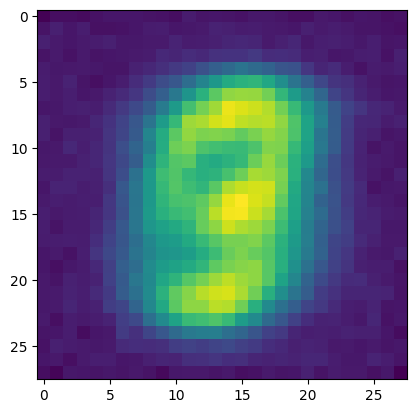

In [11]:
show_image(x_hats_02, 0)

#### Generation result when $T=5$

In [12]:
inference_n_flows = 5
x_hats_05 = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)

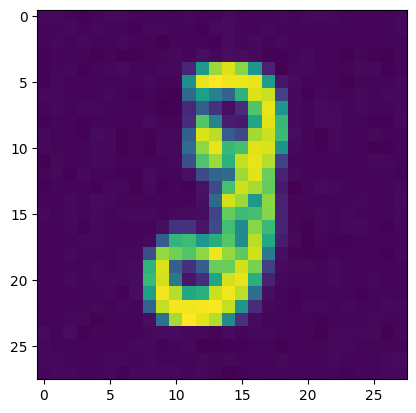

In [13]:
show_image(x_hats_05, 0)

#### Generation result when $T=10$

In [14]:
inference_n_flows = 10
x_hats_10 = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)

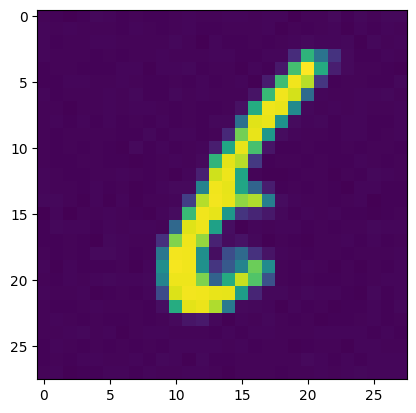

In [15]:
show_image(x_hats_10, 0)

#### Generation result when $T = 25$

In [16]:
inference_n_flows = 25
x_hats_25 = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)

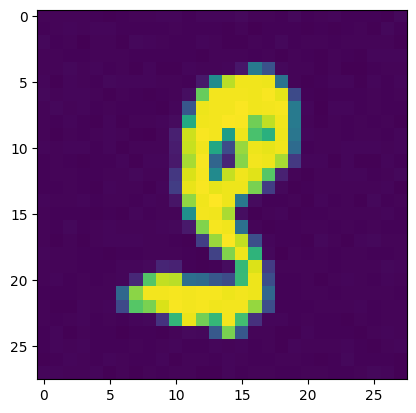

In [17]:
show_image(x_hats_25, 0)

#### Generation result when $T = 50$

In [18]:
inference_n_flows = 50
x_hats_50 = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)

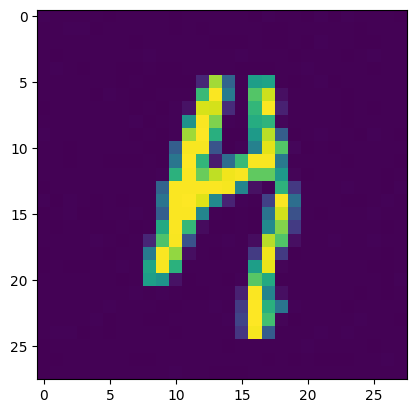

In [19]:
show_image(x_hats_50, 0)

### Comparison with Ground-truth Samples

In [20]:
B = inference_batch_size
inference_n_flows = 10
x_hats = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)

In [21]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

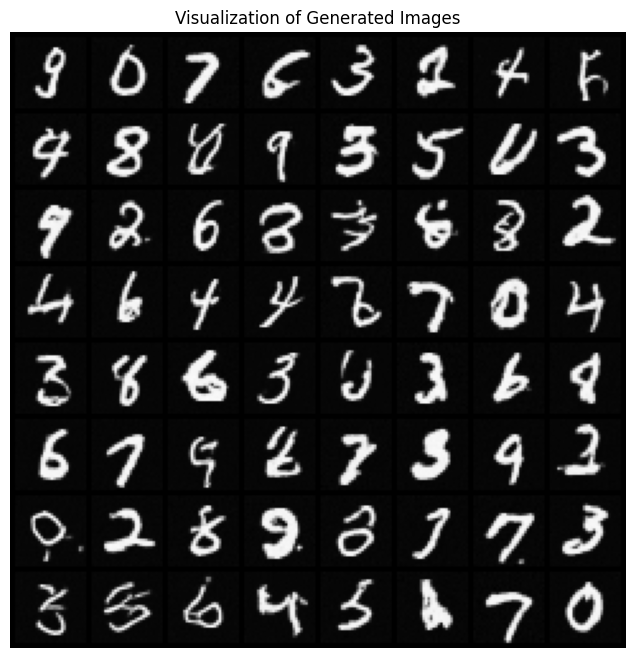

In [22]:
draw_sample_image(x_hats, "Generated Images")

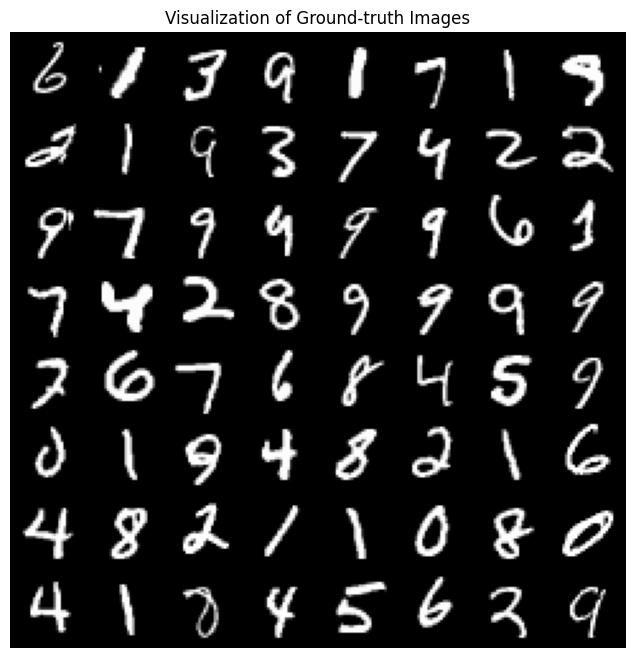

In [23]:
draw_sample_image(x_1[:inference_batch_size], "Ground-truth Images")

## References

* [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366), Chen et. al., 2018
* [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239), J. Ho et. al., 2020
* [Flow Matching for Generative Modeling](https://arxiv.org/abs/2210.02747), Lipman et. al., 2022